# Using starry process as a prior

Most of the tutorials here focus on doing inference on the statistical properties of star spots from large ensemble analyses. But what if we know (or think we know) the properties of the spots of a given star? Then we can use the GP to constrain the actual surface map of the body. This tutorial shows how to compute the mean and covariance of the GP in both spherical harmonic space and pixel space; these can be used as informative priors when mapping individual stars.

In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Disable annoying font warnings
matplotlib.font_manager._log.setLevel(50)

# Disable theano deprecation warnings
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="theano")

# Style
plt.style.use("default")
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["font.size"] = 14
plt.rcParams["text.usetex"] = False
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Liberation Sans"]
plt.rcParams["font.cursive"] = ["Liberation Sans"]
try:
    plt.rcParams["mathtext.fallback"] = "cm"
except KeyError:
    plt.rcParams["mathtext.fallback_to_cm"] = True
plt.rcParams["mathtext.fallback_to_cm"] = True

# Short arrays when printing
np.set_printoptions(threshold=0)

In [4]:
del matplotlib
del plt
del warnings

## Setup

In [5]:
from starry_process import StarryProcess
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import theano
import theano.tensor as tt

Let's instantiate a `StarryProcess` with all parameters set to their default values.

In [6]:
sp = StarryProcess()

## Prior in spherical harmonic space

Computing the GP prior in spherical harmonic space is easy. The GP mean is given by

In [7]:
mean = sp.mean_ylm.eval()
mean.shape

(256,)

where its length is just the number of spherical harmonic coefficients at the default maximum degree of the expansion, 

$$
N = (l_\mathrm{max} + 1)^2 = (15 + 1)^2 = 256
$$

We can plot this as a function of coefficient index:

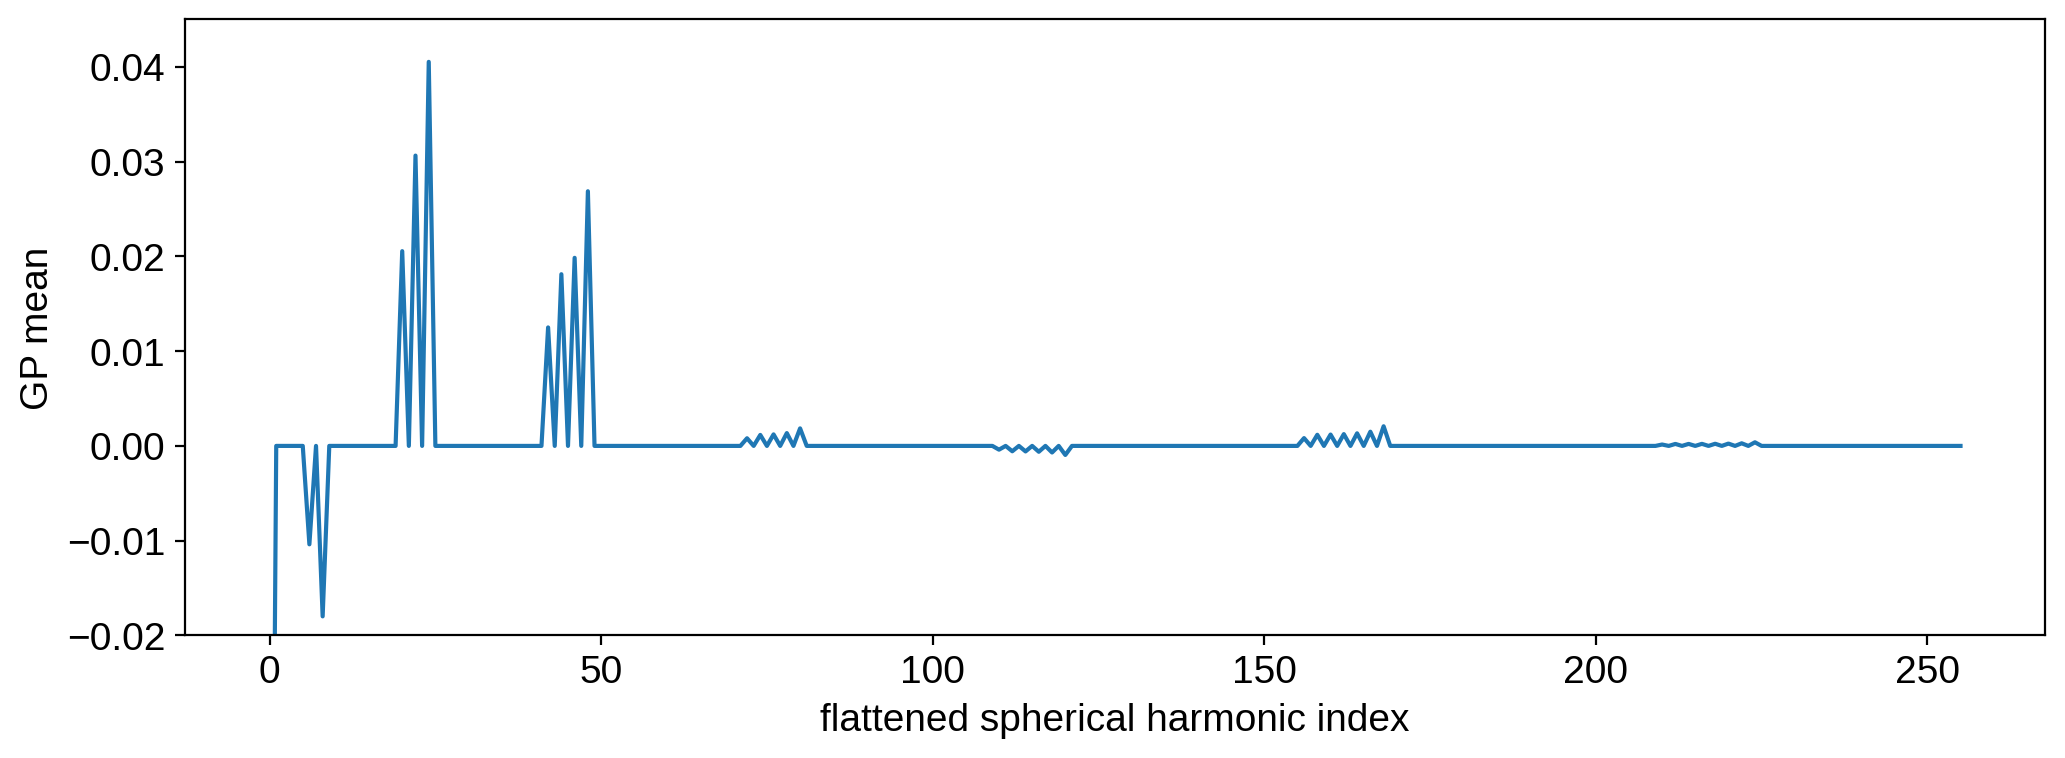

In [8]:
plt.plot(mean)
plt.ylim(-0.02, 0.045)
plt.xlabel("flattened spherical harmonic index")
plt.ylabel("GP mean")
plt.show()

This very regular pattern corresponds to the 2-band structure of the process: a band of spots at $\pm 30^\circ$ latitude. We'll see in the next section what this actually looks like in pixel space.

The GP covariance may be computed from

In [9]:
cov = sp.cov_ylm.eval()
cov.shape

(256, 256)

It's a matrix, which we can also visualize. We'll limit the plot to the first 8 spherical harmonic degrees (81 coefficients) since it's a pretty big matrix:

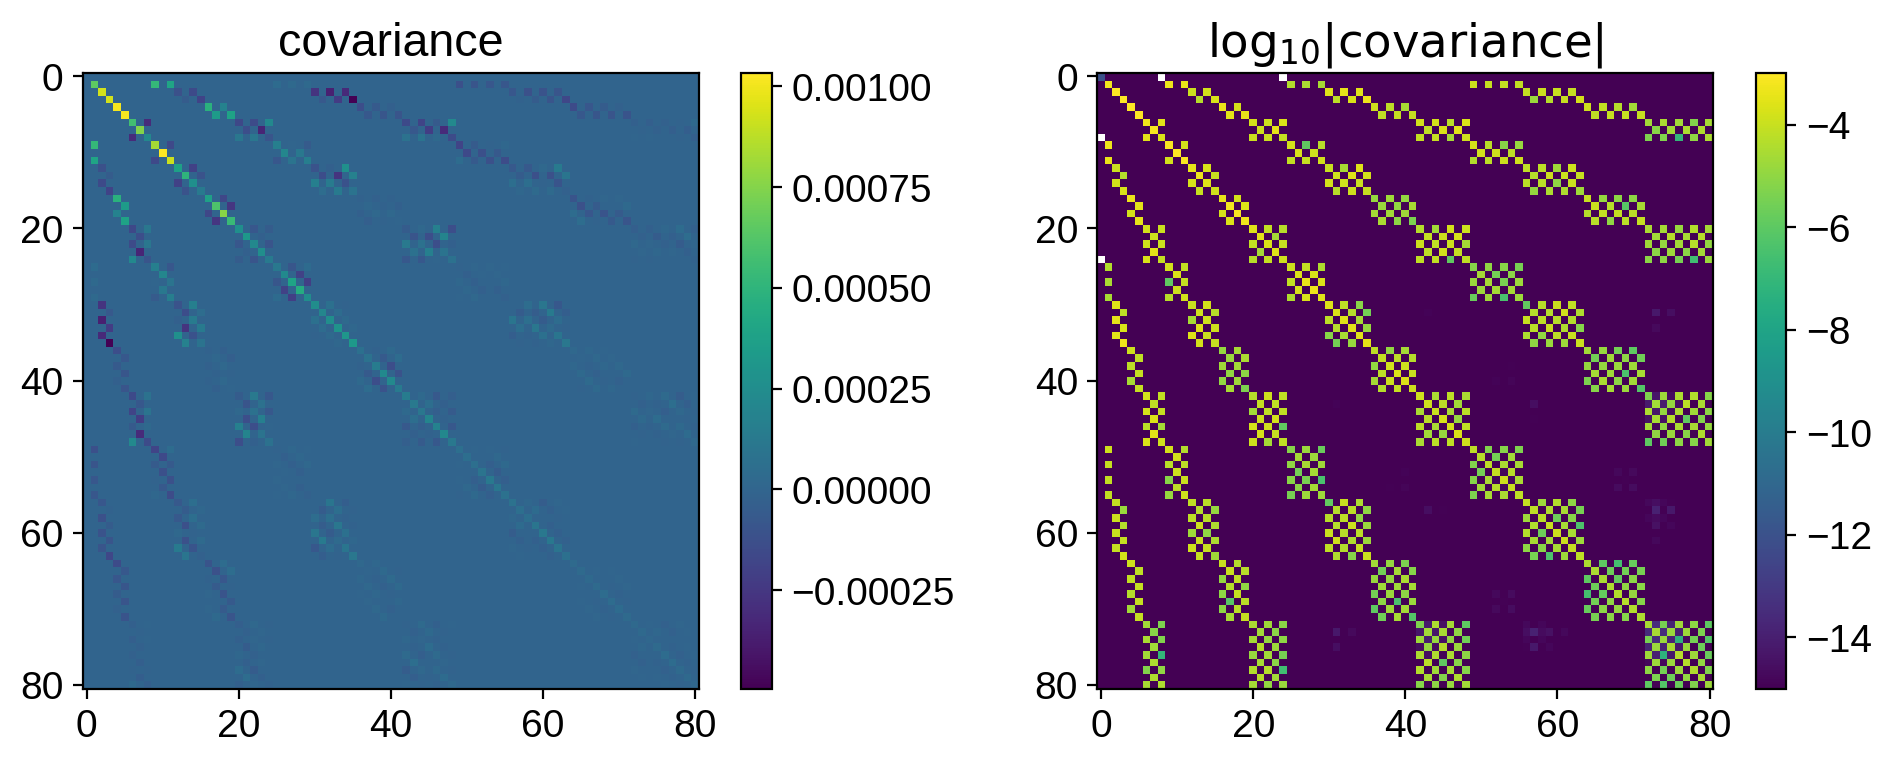

In [10]:
fig, ax = plt.subplots(1, 2)
im = ax[0].imshow(cov[:81, :81])
plt.colorbar(im, ax=ax[0])
ax[0].set_title("covariance")
im = ax[1].imshow(np.log10(np.abs(cov[:81, :81])), vmin=-15)
plt.colorbar(im, ax=ax[1])
ax[1].set_title("$\log_{10}|\mathrm{covariance}|$")
plt.show()

The structure certainly isn't trivial: it encodes everything about the size, location, contrast, and number of spots.

Now that we have the GP mean vector ``mean`` and the GP covariance matrix ``cov``, we effectively have a prior for doing inference. This is useful when mapping stellar surfaces with the ``starry`` code, which accepts a spherical harmonic mean vector and covariance matrix as a prior (see [here](https://luger.dev/starry/v1.0.0/notebooks/EclipsingBinary_Linear.html#Linear-solve)).

## Prior in pixel space

For some applications (particularly those not using ``starry``), it may be useful to compute the prior in pixel space. This is helpful if one is attempting to map the stellar surface directly in the pixel basis (i.e., the model is computed on a gridded stellar surface, and the model parameters are the actual pixel intensities). Since there is a linear relationship between spherical harmonic coefficients and pixels, it is very easy to convert between the two.

To visualize the GP mean in pixel space, let's create a grid of latitude-longitude points in degrees:

In [11]:
lat = np.linspace(-90, 90, 50)
lon = np.linspace(-180, 180, 100)

Let's turn this into a vector of ``(lat, lon)`` tuples...

In [12]:
latlon = np.transpose(np.meshgrid(lat, lon))

and feed it into ``sp.mean_pix`` to compute the process mean:

In [13]:
mean = sp.mean_pix(latlon).eval()
mean.shape

(5000,)

The mean computed by ``StarryProcess`` is flattened, so we can unravel it back into the dimensions of our grid to visualize it:

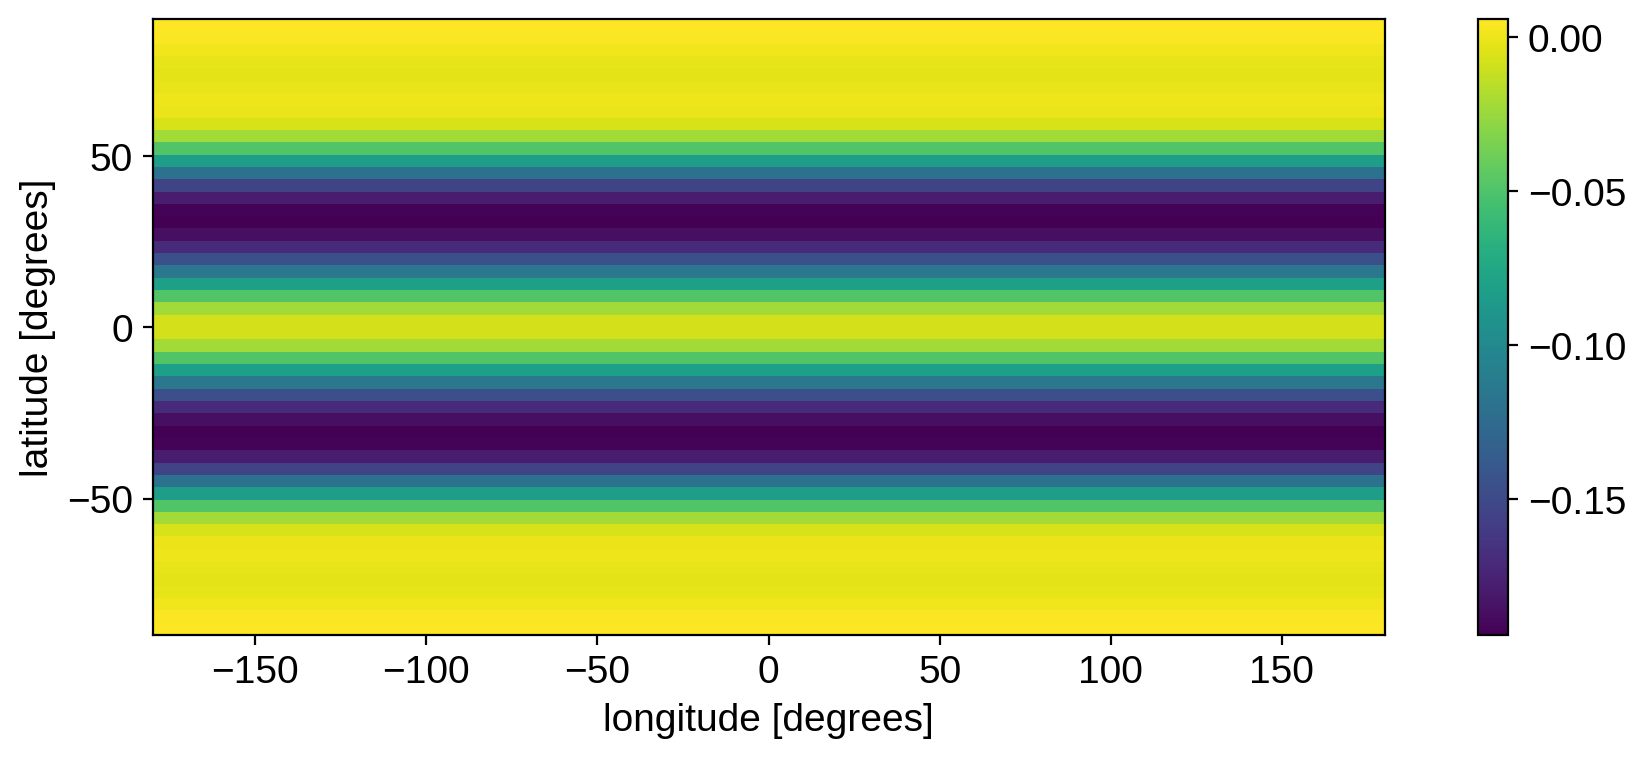

In [14]:
plt.imshow(mean.reshape(50, 100), origin="lower", extent=(-180, 180, -90, 90))
plt.colorbar()
plt.xlabel("longitude [degrees]")
plt.ylabel("latitude [degrees]")
plt.show()

The prior mean corresponds to dark bands at mid-latitudes. Even though ``StarryProcess`` models circular spots, it is a longitudinally isotropic process, so there's no preferred longitude at which to place the spots. The prior mean is therefore just a spot that's been "smeared out" longitudinally. All of the information about how spots emerge from this pattern is encoded in the covariance matrix (see below).

You can experiment with passing different values for the spot latitude parameters when instantiating the ``StarryProcess`` to see how that affects the mean.

The covariance may be computed from

In [15]:
cov = sp.cov_pix(latlon).eval()
cov.shape

(5000, 5000)

Again, this is flattened. Let's attempt to visualize it (again restricting to the first few hundred coefficients):

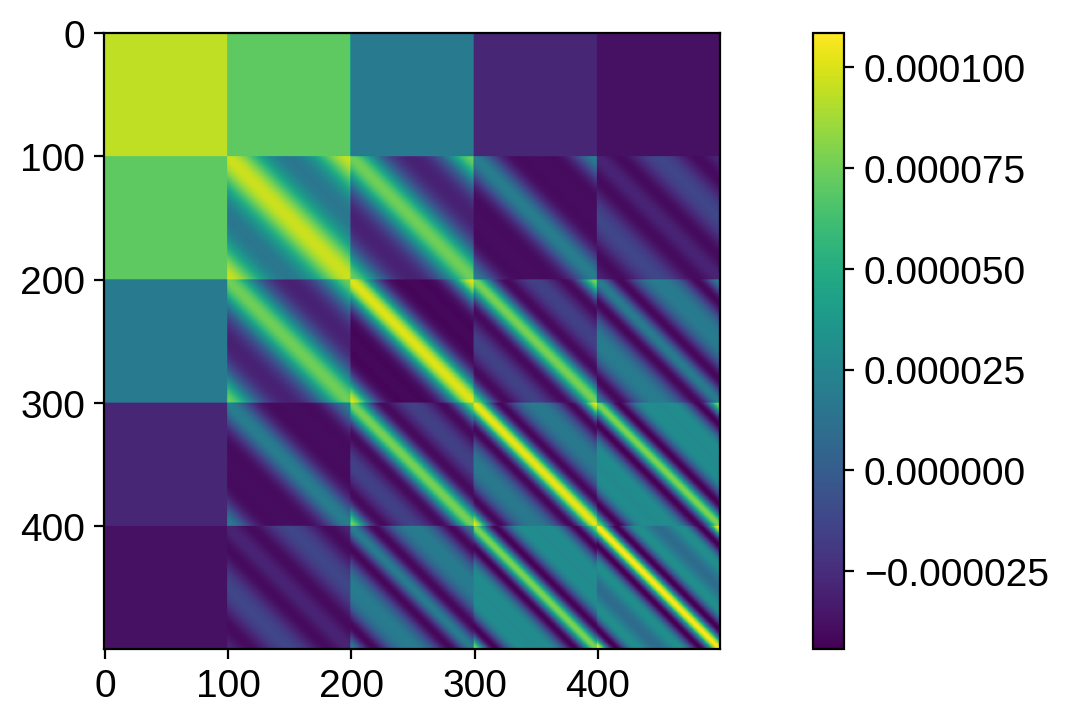

In [16]:
plt.imshow(cov[:500, :500])
plt.colorbar()
plt.show()

That looks pretty wonky! In general, it's much harder to visualize covariances in pixel space, since it's inherently 4-d! We can settle instead for visualizing the *variance*, which is 2d, and tells us how much scatter there is at every point on the grid when we sample from the prior:

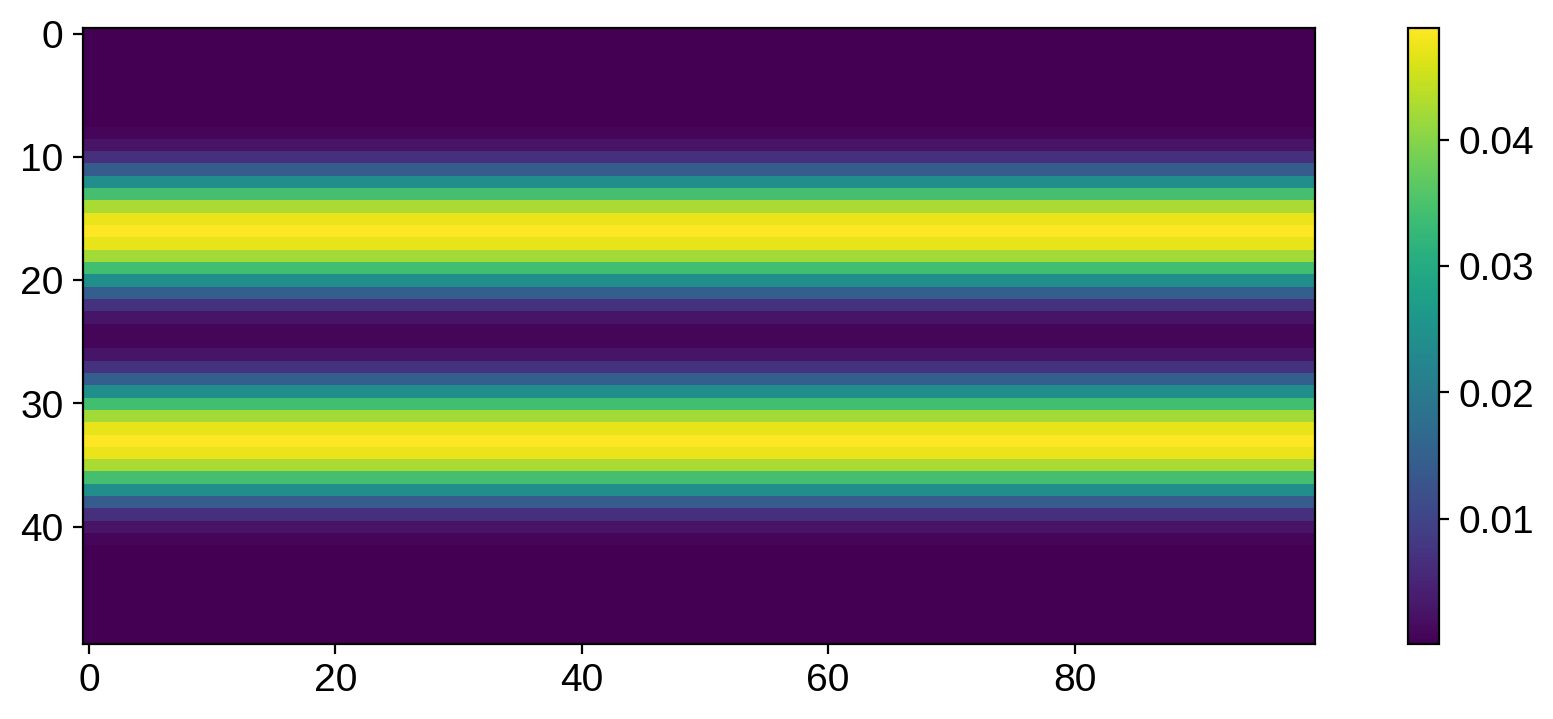

In [17]:
plt.imshow(np.diag(cov).reshape(50, 100))
plt.colorbar()
plt.show()

We see the same banded structure as before, but now we have *positive* values in the bands and values close to zero outside of the bands. This is exactly what we'd expect: the variance is high within the bands (that's where all the spots live, and where we expect the samples to differ from each other) and zero outside (where the surface should be close to the unspotted mean level).